In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statistics as st 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns

# EDA

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Remove listing_id  
#### listing_id is all unique without duplicates

In [3]:
train = train.drop(columns=['listing_id', 'property_details_url', 'elevation','property_name','address','title'])
test = test.drop(columns=['listing_id', 'property_details_url', 'elevation','property_name','address','title'])

In [4]:
train.describe()

built_year      num_beds     num_baths     size_sqft  \
count  19332.000000  20174.000000  19820.000000  2.025400e+04   
mean    2010.833695      3.122931      2.643542  1.854364e+03   
std       15.822803      1.281658      1.473835  1.354343e+04   
min     1963.000000      1.000000      1.000000  0.000000e+00   
25%     2000.000000      2.000000      2.000000  8.070000e+02   
50%     2017.000000      3.000000      2.000000  1.119000e+03   
75%     2023.000000      4.000000      3.000000  1.528000e+03   
max     2028.000000     10.000000     10.000000  1.496000e+06   

       total_num_units           lat           lng         price  
count     14602.000000  20254.000000  20254.000000  2.025400e+04  
mean        376.253938      1.434282    103.855356  5.228263e+06  
std         346.882474      1.558472      3.593441  2.779748e+08  
min           4.000000      1.239621    -77.065364  0.000000e+00  
25%         106.000000      1.307329    103.806576  8.190000e+05  
50%         296.000000      1.329266    103.841552  1.680000e+06  
75%         561.000000      1.372461    103.881514  3.242400e+06  
max        2612.000000     69.486768    121.023232  3.924243e+10

## Adding Distances

### Add distance to commericial centres

In [5]:
ccdistance = pd.read_csv('auxiliary-data/sg-commerical-centres.csv')

In [6]:
# vectorized haversine function
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


In [7]:
# train['cc_distance'] = haversine_np(train['lng'], train['lat'], ccdistance['lng'], ccdistance['lat'])
expected_result = pd.merge(train, ccdistance, on = 'planning_area')
expected_result.head()
train['cc_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# train['cc_distance'] = haversine_np(train['lng'], train['lat'], ccdistance['lng'], ccdistance['lat'])
expected_result = pd.merge(test, ccdistance, on = 'planning_area')
expected_result.head()
test['cc_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [8]:
ccdistancemean = train['cc_distance'].median()
train['cc_distance']=train['cc_distance'].fillna(ccdistancemean)

ccdistancemean = test['cc_distance'].median()
test['cc_distance']=test['cc_distance'].fillna(ccdistancemean)

### Add distance to mrt stations

In [9]:
# using long and lat
mrtdistance = pd.read_csv('auxiliary-data/sg-mrt-stations.csv')
expected_result = pd.merge(train, mrtdistance, on = 'planning_area')
train['mrt_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])


# using long and lat
mrtdistance = pd.read_csv('auxiliary-data/sg-mrt-stations.csv')
expected_result = pd.merge(test, mrtdistance, on = 'planning_area')
test['mrt_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

### Add distance to primary school 

In [10]:
# using long and lat
primaryschooldistance = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
expected_result = pd.merge(train, primaryschooldistance, on = 'planning_area')
train['primary_school_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
primaryschooldistance = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
expected_result = pd.merge(test, primaryschooldistance, on = 'planning_area')
test['primary_school_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

### Add distance to secondary school

In [11]:
# using long and lat
secschooldistance = pd.read_csv('auxiliary-data/sg-secondary-schools.csv')
expected_result = pd.merge(train, secschooldistance, on = 'planning_area')
train['secondary_school_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
secschooldistance = pd.read_csv('auxiliary-data/sg-secondary-schools.csv')
expected_result = pd.merge(test, secschooldistance, on = 'planning_area')
test['secondary_school_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

### Add distance to shopping malls

In [12]:
# using long and lat
shop_distance = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
expected_result = pd.merge(train, secschooldistance, on = 'planning_area')
train['shop_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
shop_distance = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
expected_result = pd.merge(test, secschooldistance, on = 'planning_area')
test['shop_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [13]:
train.head()

property_type             tenure  built_year  num_beds  num_baths  \
0   hdb 4 rooms                NaN      1988.0       3.0        2.0   
1           hdb  99-year leasehold      1992.0       4.0        2.0   
2         condo           freehold      2022.0       4.0        6.0   
3         Condo           freehold      2023.0       3.0        2.0   
4         condo  99-year leasehold      2026.0       2.0        1.0   

   size_sqft floor_level   furnishing      available_unit_types  \
0       1115         NaN  unspecified                       NaN   
1       1575         NaN  unspecified       1, 2, 3, 4, 5, 6 br   
2       3070         low      partial     studio, 3, 4, 5, 6 br   
3        958         NaN      partial     studio, 1, 2, 3, 4 br   
4        732         NaN  unspecified  studio, 1, 2, 3, 4, 5 br   

   total_num_units       lat         lng          subzone  planning_area  \
0            116.0  1.414399  103.837196     yishun south         yishun   
1              NaN  1.372597  103.875625  serangoon north      serangoon   
2             56.0  1.298773  103.895798      mountbatten  marine parade   
3            638.0  1.312364  103.803271     farrer court    bukit timah   
4            351.0  1.273959  103.843635            anson  downtown core   

       price  cc_distance  mrt_distance  primary_school_distance  \
0   514500.0     8.027727      1.689357                 5.178683   
1   995400.0     2.400374      6.871207                 8.310177   
2  8485000.0     6.389766     13.983476                 9.485153   
3  2626000.0     8.802339     13.479646                 3.290085   
4  1764000.0     9.160635     15.981982                13.818954   

   secondary_school_distance  shop_distance  
0                   2.538065       2.538065  
1                   6.710202       6.710202  
2                  15.197137      15.197137  
3                  12.950660      12.950660  
4                  17.977600      17.977600

In [14]:
train['cc_distance'].describe()

count    20254.000000
mean        26.050066
std        332.803030
min          0.089512
25%          7.140757
50%         10.324064
75%         13.319652
max      15529.817405
Name: cc_distance, dtype: float64

## Property Type cleaning

In [15]:
#Change all to uppercase
train['property_type']=train['property_type'].str.upper()

#Change all to uppercase
test['property_type']=test['property_type'].str.upper()

In [16]:
#for regression only
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['property_type'])
train['property_type']=le.transform(train['property_type'])

test['property_type']=le.transform(test['property_type'])

## Tenure 

In [17]:
train['tenure'] = train['tenure'].replace(
    [
    '99-year leasehold',
    '110-year leasehold',
    '103-year leasehold',
    '102-year leasehold',
    '100-year leasehold',
    ],
    '99-year leasehold'
)

train['tenure'] = train['tenure'].replace(
    [
    '946-year leasehold',
    '999-year leasehold',
    '956-year leasehold',
    '929-year leasehold',
    '947-year leasehold',
    ],
    '999-year leasehold'
)



test['tenure'] = test['tenure'].replace(
    [
    '99-year leasehold',
    '110-year leasehold',
    '103-year leasehold',
    '102-year leasehold',
    '100-year leasehold',
    ],
    '99-year leasehold'
)

test['tenure'] = test['tenure'].replace(
    [
    '946-year leasehold',
    '999-year leasehold',
    '956-year leasehold',
    '929-year leasehold',
    '947-year leasehold',
    ],
    '999-year leasehold'
)

In [18]:
test['tenure'] = test['tenure'].fillna('99-year leasehold')

In [19]:
train['tenure'] = train['tenure'].fillna('99-year leasehold')

In [20]:
## Remove NA 
train = train.dropna(subset=['tenure'])

## Remove NA 
test['tenure'] = test['tenure'].fillna('99-year leasehold')

In [ ]:
#for regression only

from sklearn import preprocessing
tenurepp = preprocessing.LabelEncoder()
tenurepp.fit(train['tenure'])
train['tenure']=tenurepp.transform(train['tenure'])

test['tenure']=tenurepp.transform(test['tenure'])

### Funishing

In [21]:
#Assume not specified and na as unfurnished 
train['furnishing'] = train['furnishing'].replace(
    [
    'na',
    'unspecified',
    ],
    'unfurnished'
)

#Assume not specified and na as unfurnished 
test['furnishing'] = test['furnishing'].replace(
    [
    'na',
    'unspecified',
    ],
    'unfurnished'
)

In [ ]:
#for regression only

from sklearn import preprocessing
furnishing = preprocessing.LabelEncoder()
furnishing.fit(train['furnishing'])
train['furnishing']=furnishing.transform(train['furnishing'])

test['furnishing']=furnishing.transform(test['furnishing'])

## floor_level 

In [22]:
# Too few data for floor level, we should just take out the column
train = train.drop(columns='floor_level')

# Too few data for floor level, we should just take out the column
test = test.drop(columns='floor_level')

## total_num_units

In [23]:
mediantotalunit = train['total_num_units'].median()
train['total_num_units'].fillna(mediantotalunit, inplace=True)

mediantotalunit = test['total_num_units'].median()
test['total_num_units'].fillna(mediantotalunit, inplace=True)

## build year

In [24]:
avgbuildyear = round(train['built_year'].median(),0)
train['built_year'] = train['built_year'].fillna(avgbuildyear)

avgbuildyear = round(test['built_year'].median(),0)
test['built_year'] = test['built_year'].fillna(avgbuildyear)

## num_baths

In [ ]:
train.head()

In [25]:
a = train[train['num_baths'].isna()]
a[a['num_beds'].isna()]

property_type             tenure  built_year  num_beds  num_baths  \
3713               1           freehold      1990.0       NaN        NaN   
4691               3  99-year leasehold      2023.0       NaN        NaN   
4939               8  99-year leasehold      1980.0       NaN        NaN   
5002               8  99-year leasehold      2004.0       NaN        NaN   
11500              8  99-year leasehold      1985.0       NaN        NaN   

       size_sqft   furnishing         available_unit_types  total_num_units  \
3713        9594  unfurnished     studio, 1, 4, 5, 6, 7 br            296.0   
4691         431  unfurnished  studio, 1, 2, 3, 4, 5, 8 br            774.0   
4939         731  unfurnished                          NaN            112.0   
5002        1184  unfurnished                          NaN             90.0   
11500        786  unfurnished           studio, 2, 3, 4 br            296.0   

            lat         lng           subzone planning_area       price  \
3713   1.319714  103.829907           malcolm        novena  16275000.0   
4691   1.283016  103.839887      pearl's hill        outram   1222200.0   
4939   1.331612  103.924833       bedok north         bedok    367500.0   
5002   1.403418  103.896423           matilda       punggol    669900.0   
11500  1.349904  103.756987  bukit batok east   bukit batok    409500.0   

       cc_distance  mrt_distance  primary_school_distance  \
3713      5.668353      5.872226                 6.905858   
4691      5.825357      8.355056                11.798265   
4939     15.229001      7.025831                 8.583307   
5002     16.664632      6.751215                 7.404180   
11500     8.707527      4.914059                 6.279880   

       secondary_school_distance  shop_distance  
3713                   11.134265      11.134265  
4691                   15.372730      15.372730  
4939                   13.354867      13.354867  
5002                    7.477411       7.477411  
11500                  18.454836      18.454836

In [26]:
avgbath = train['num_baths'].median
train['num_baths'] = train['num_baths'].fillna(avgbath)

avgbath = test['num_baths'].median()
test['num_baths'] = test['num_baths'].fillna(avgbath)

## num_bedds

In [27]:
avgbed = train['num_beds'].median()
train['num_beds'] = train['num_beds'].fillna(avgbath)

avgbed = test['num_beds'].median()
test['num_beds'] = test['num_beds'].fillna(avgbath)

## num_avaliable_units

In [28]:
numavaunittypes = train.available_unit_types.str.count(',') + 1
train['available_unit_types'] = numavaunittypes

In [29]:
avg_ava_units = train['available_unit_types'].median()
train['available_unit_types'] = train['available_unit_types'].fillna(avg_ava_units)

In [30]:
numavaunittypes = test.available_unit_types.str.count(',') +1
test['available_unit_types'] = numavaunittypes

avg_ava_units = test['available_unit_types'].median()
test['available_unit_types'] = test['available_unit_types'].fillna(avg_ava_units)

## Subzone & planning zone

In [31]:
pa = train['planning_area'] + test['planning_area']
pa = pa.dropna().drop_duplicates().unique()
pa = pd.DataFrame(pa)
pa.count()

0    1292
dtype: int64

In [32]:
a = train['planning_area'].drop_duplicates()
b = test['planning_area'].drop_duplicates()
c = pd.concat([a, b]).dropna()
c = c.drop_duplicates()


In [ ]:
from sklearn import preprocessing
planningzone = preprocessing.LabelEncoder()
planningzone.fit(c)

train = train.dropna()
train['planning_area']=planningzone.transform(train['planning_area'])

In [ ]:
mostfreq = test['planning_area'].mode()
mostfreq
test['planning_area'] = test['planning_area'].fillna('bukit timah')
test['planning_area']=planningzone.transform(test['planning_area'])

In [ ]:
train.head()

#### psf

In [33]:
price_per_sqft = train['price']/train['size_sqft']

In [34]:
train['price_per_sqft'] = price_per_sqft

## Data Visualization

#### built_year

In [35]:
train['built_year'] = train['built_year'].astype(int)

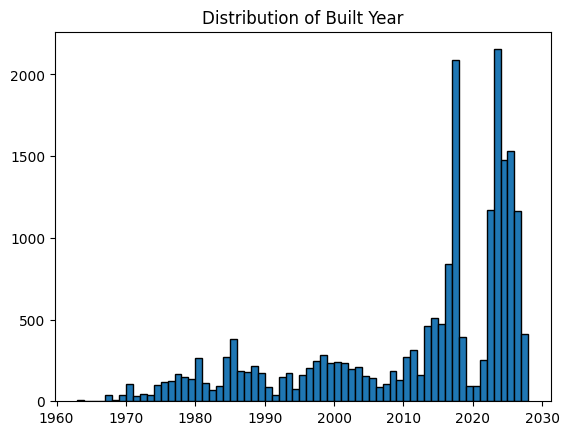

In [36]:
bins = train['built_year'].max() - train['built_year'].min()
plt.hist(train['built_year'], bins=bins, edgecolor='black')
plt.title('Distribution of Built Year')
plt.show()

#### 

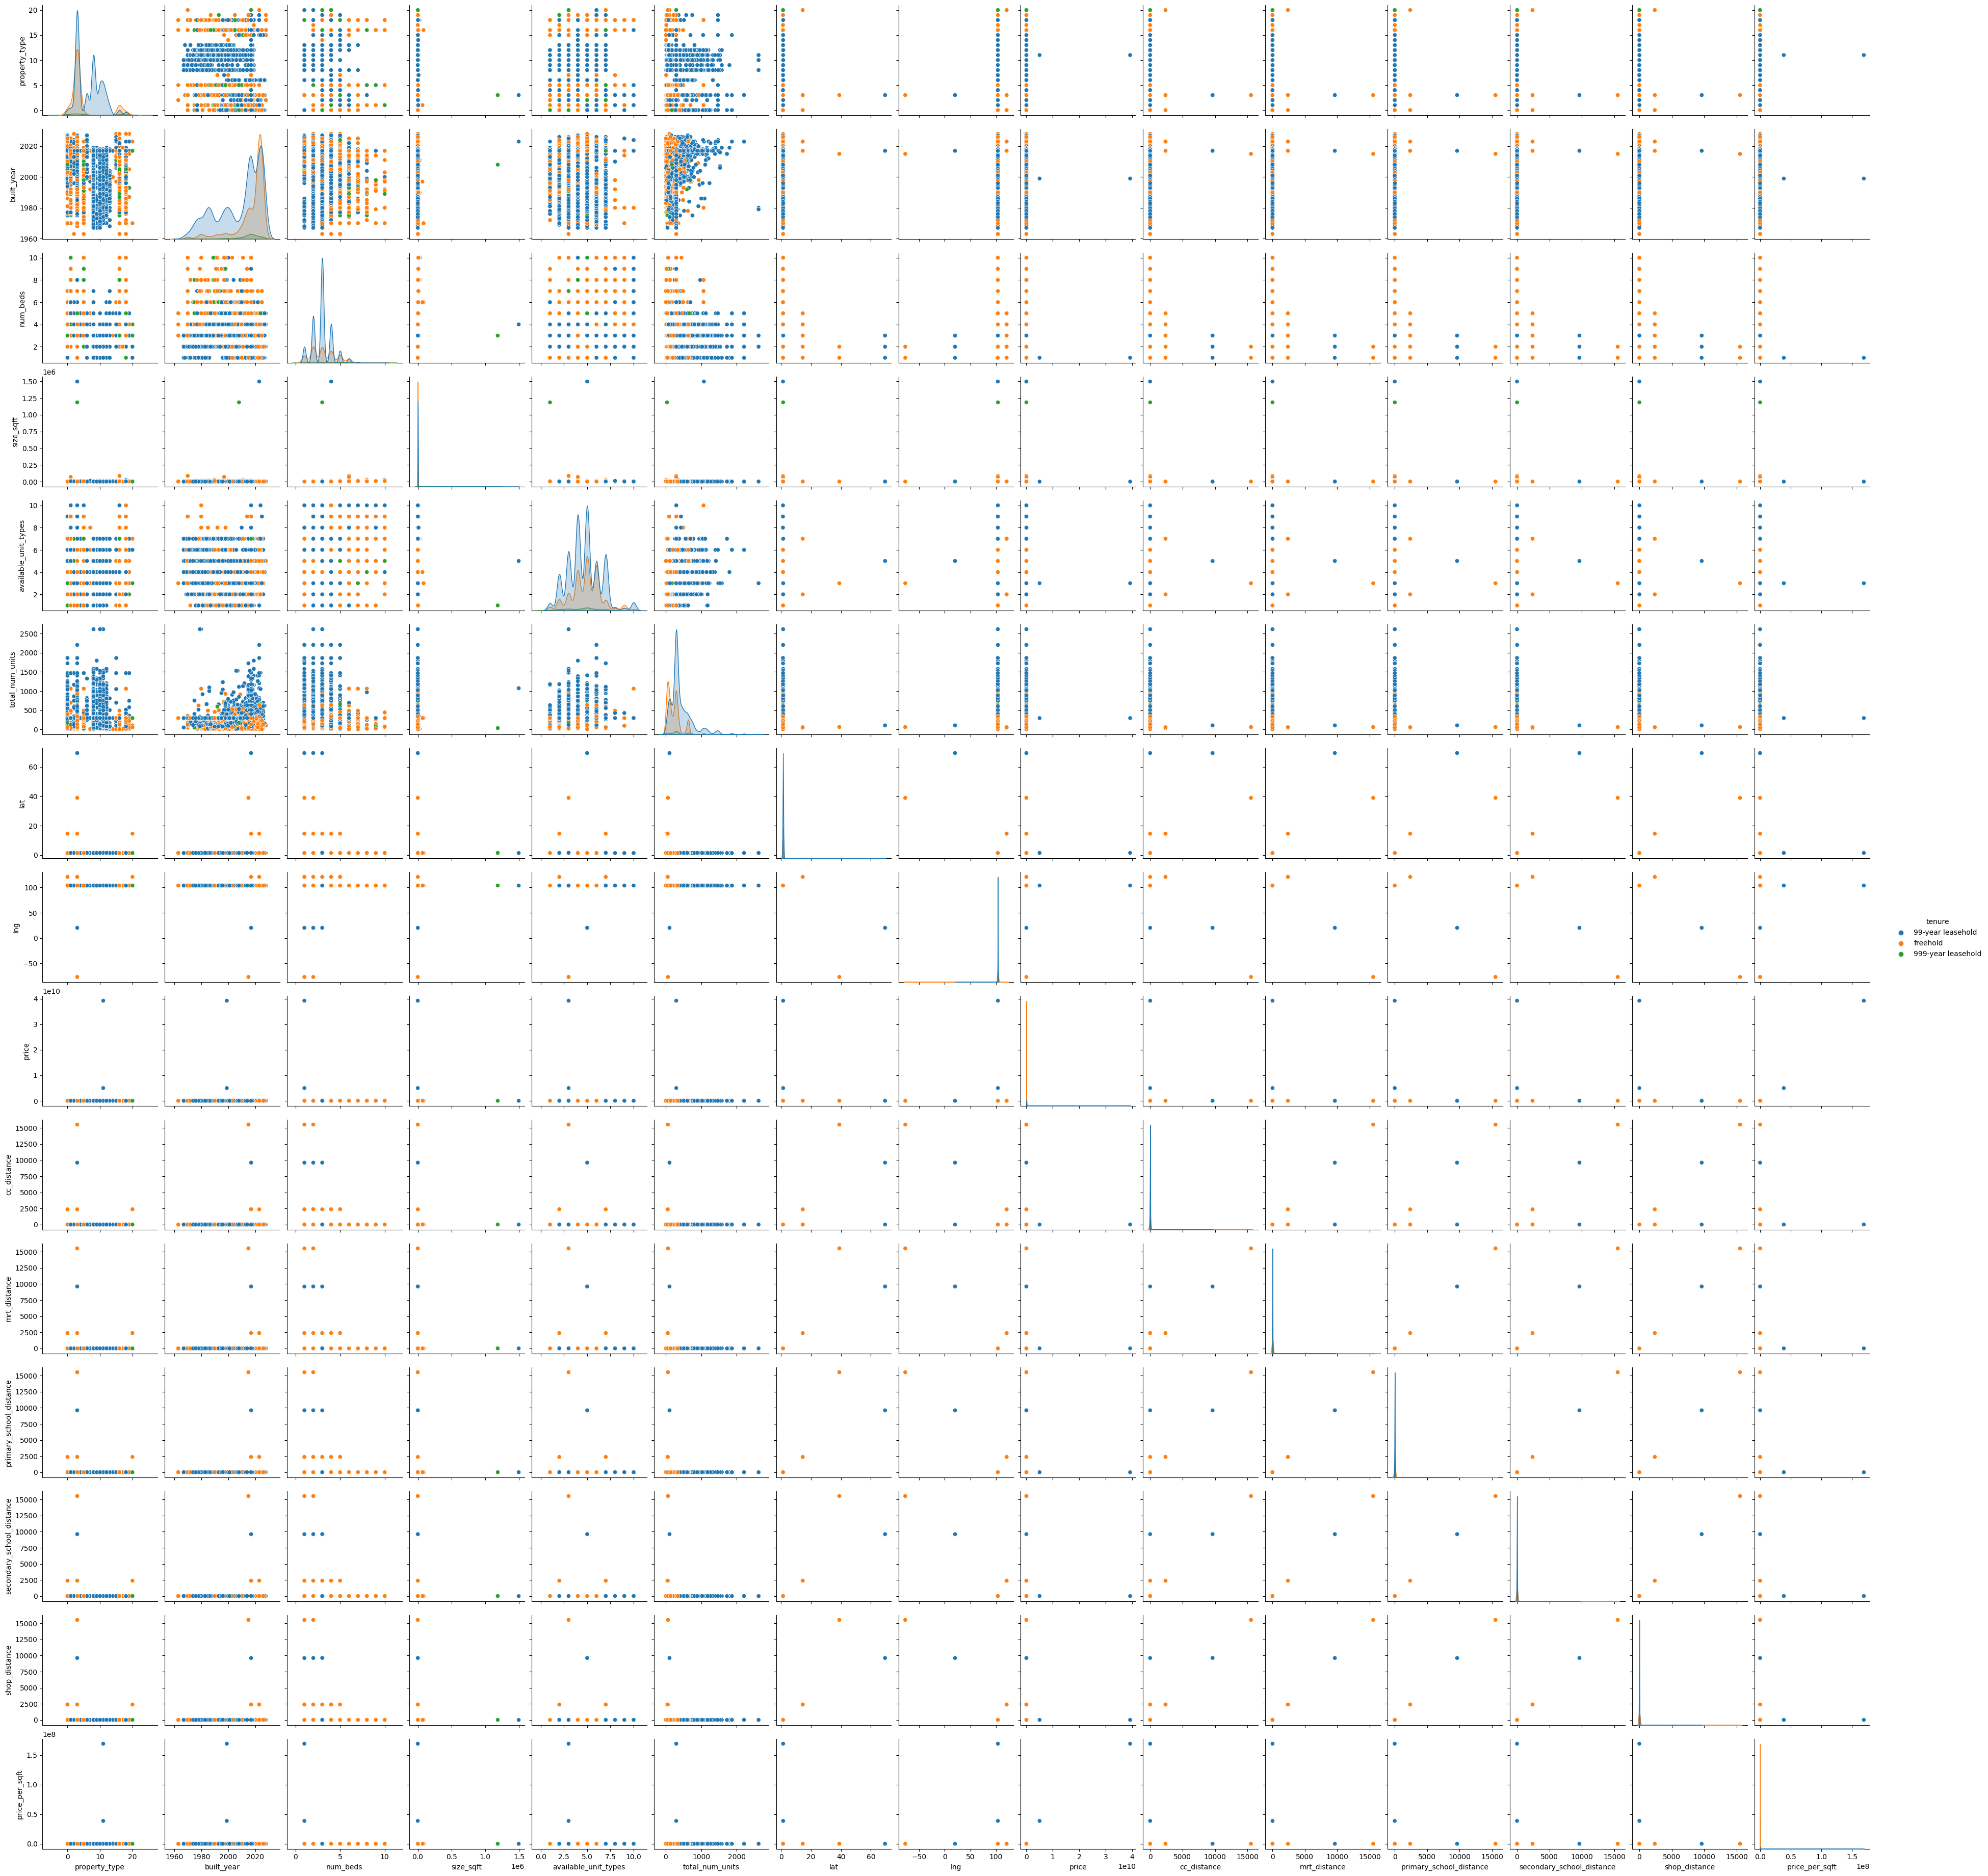

In [45]:
sns.pairplot(data=train, hue="tenure")

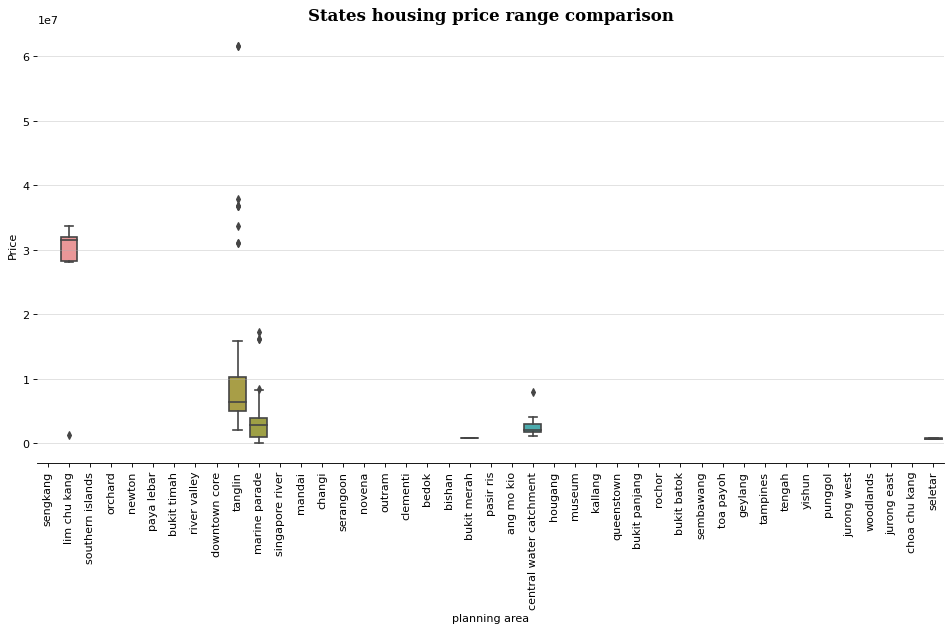

In [38]:
# Visualization
fig, ax = plt.subplots(1,1, figsize=(12, 8), dpi=80)

# Find the order
my_order = train.groupby(by=["planning_area"])["price"].mean().sort_values(ascending=False).index

box_plot = sns.boxplot(x = 'subzone',y = 'price',data = train, order=my_order)
plt.ylabel('Price')
plt.xlabel('planning area')
plt.title('Planning Area housing price range comparison', fontsize=15, fontweight='bold', fontfamily='serif')

ax = box_plot.axes

lines = ax.get_lines()
#categories = ax.get_xticks()
ax.tick_params(axis='x', rotation=90)

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4) 

box_plot.figure.tight_layout()

#fig = box_plot.get_figure()

<AxesSubplot:>

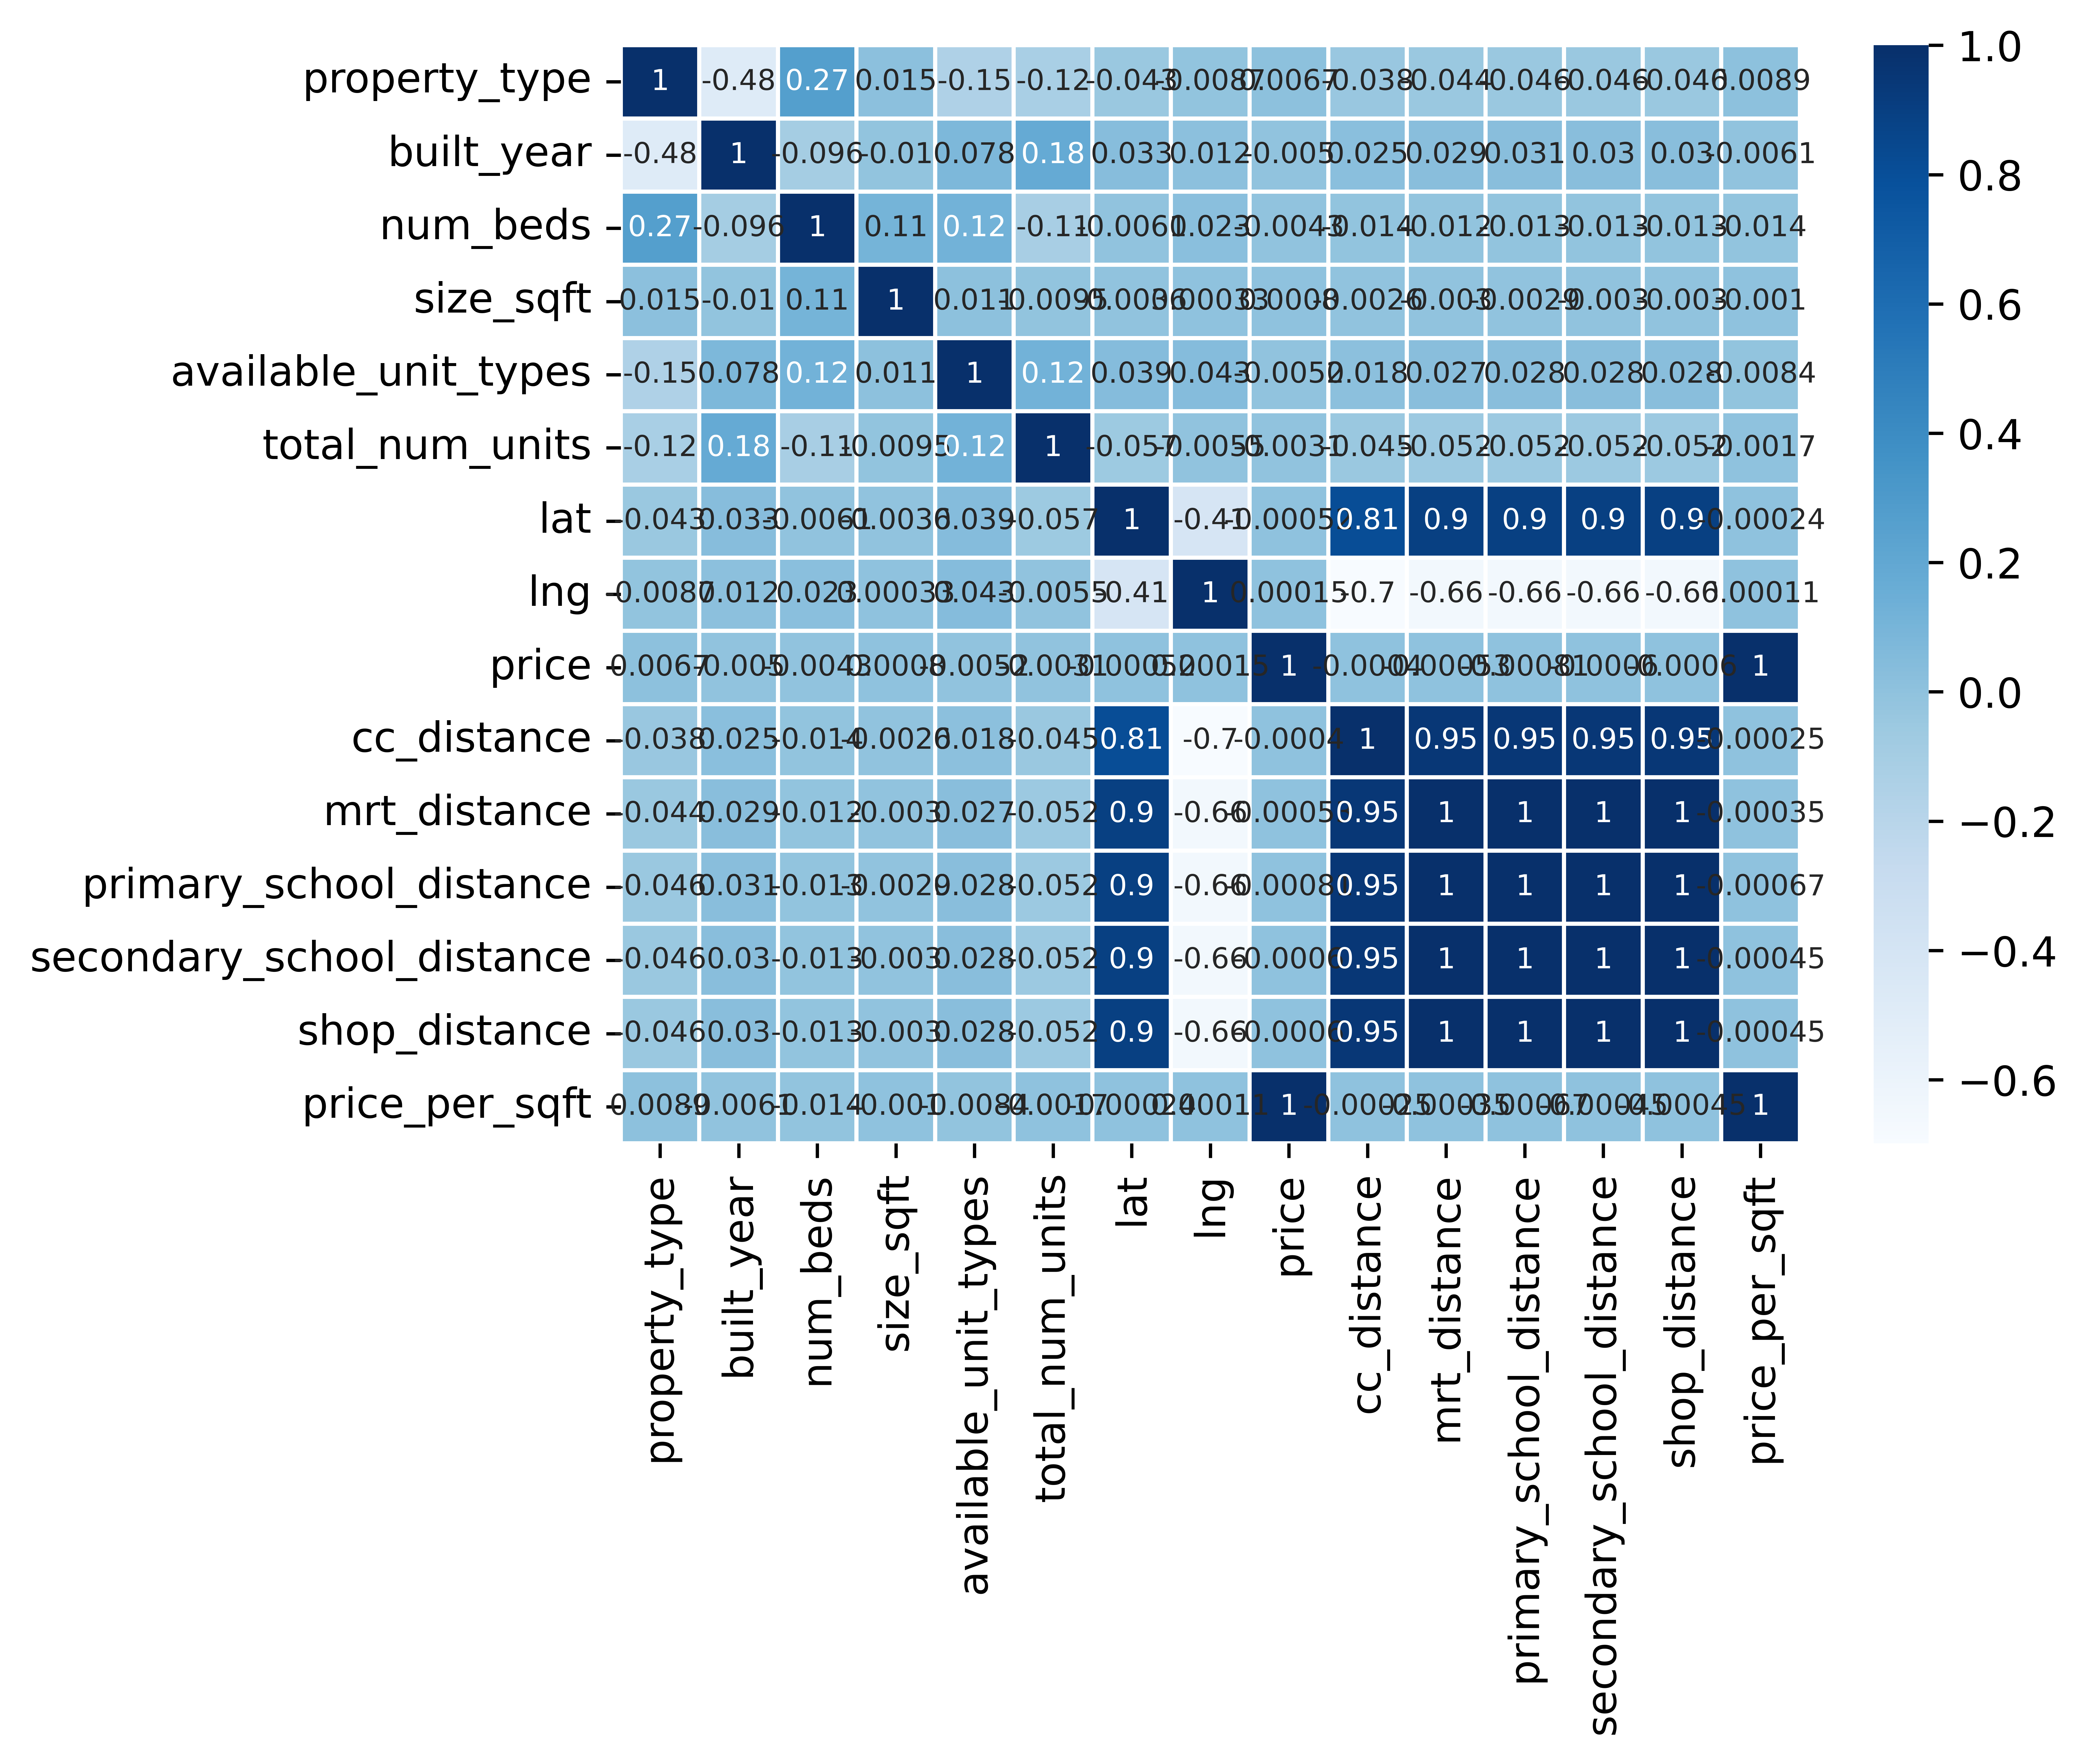

In [53]:
plt.figure(dpi=1000)
sns.heatmap(train.corr(), linewidths=1,cmap="Blues",annot=True, annot_kws={'size':7})

<AxesSubplot:xlabel='cc_distance', ylabel='price_per_sqft'>

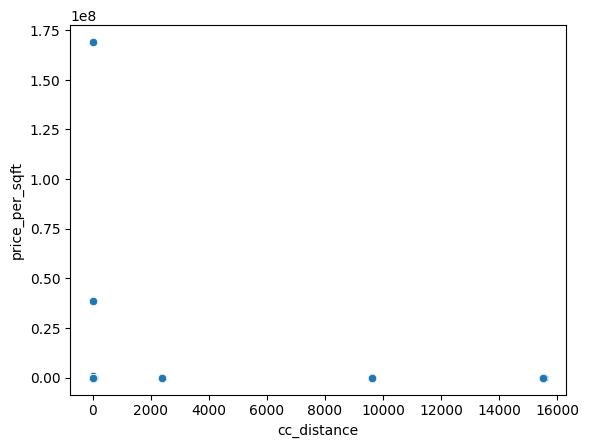

In [51]:
sns.scatterplot(data=train, x='cc_distance',y='price_per_sqft')

## Data MINING

In [ ]:
'''Main'''
import numpy as np
import pandas as pd
from time import time

'''Data Prep'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# data visualisation
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier as xgb

In [ ]:
dataX = train.copy()
dataY = dataX.pop('price')

X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=88)

In [ ]:
# important sample code
# parameter tuning for random forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {'max_features':('sqrt', 'log2'), 'n_estimators':range(10, 100, 5)} # from 10 to 100 with 5 increment

clf = RandomForestClassifier(
    n_jobs=-1, # for using multiple cpu/core to speed up calculation
    random_state=2022, # random seed
    verbose=0, # print out details or not    
)

clf2 = GridSearchCV(clf, param_grid=params, scoring='accuracy', cv=5)
clf2.fit(X_train, y_train)

# see all output variables in cv results
sorted(clf2.cv_results_.keys())

In [ ]:
clf2.best_score_

In [ ]:
# get the best model
clf2.best_estimator_

In [ ]:
print("Accuracy on training set: {:.3f}".format(clf2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(clf2.score(X_test, y_test)))